Fit simple linear/polynomial regression model for exposure factors from updated sky model. The updated sky model is a refit Kriscunas and Schaefer (1991) (to BOSS sky spectra data) plus a twilight contribution.

In [1]:
import os
import pickle
import numpy as np 
# -- feasibgs 
from feasibgs import util as UT
from feasibgs import skymodel as Sky
# -- plotting -- 
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False


>>> from astroplan import download_IERS_A
>>> download_IERS_A()
 [astroplan.utils]


In [2]:
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

In [3]:
# --- desihub ---
import desisim.simexp 

/anaconda2/envs/gqp/lib/python3.7/site-packages/desitarget-0.22.0-py3.7.egg/desitarget/targetmask.py:22: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  _bitdefs = yaml.load(fx)
/anaconda2/envs/gqp/lib/python3.7/site-packages/desispec-0.22.1-py3.7.egg/desispec/maskbits.py:73: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  """)


In [4]:
# nominal dark sky
wave_lin    = np.linspace(3.6e3, 9.8e3, 62001) 
config      = desisim.simexp._specsim_config_for_wave(wave_lin, dwave_out=None, specsim_config_file='desi')
atm_config  = config.atmosphere
sb_dict     = config.load_table(atm_config.sky, 'surface_brightness', as_dict=True)
Isky_dark   = sb_dict['dark'] 

In [5]:
from scipy.signal import medfilt2d
from scipy.interpolate import interp1d

def _get_continuum(sb, width=1001): 
    ''' get continuum of given surfrace brightness 
    '''
    sb = np.atleast_2d(sb) 
    continuum = medfilt2d(sb, [1, width]) 
    return continuum

In [6]:
Isky_cont_dark = _get_continuum(Isky_dark)[0]

Text(0.5, 1.0, 'Nominal Dark Sky Surface Brightness')

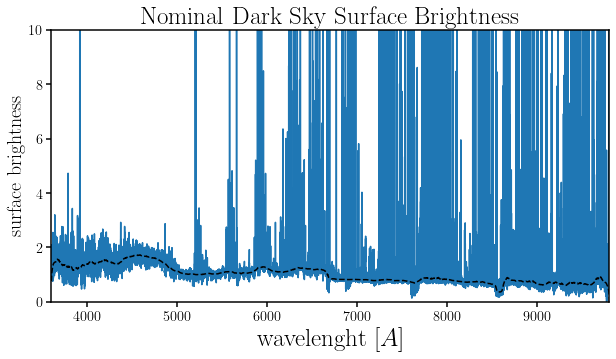

In [7]:
fig = plt.figure(figsize=(10,5))
sub = fig.add_subplot(111)
sub.plot(wave_lin, Isky_dark, c='C0')
sub.plot(wave_lin, Isky_cont_dark, c='k', ls='--')
sub.set_xlabel('wavelenght [$A$]', fontsize=25)
sub.set_xlim(3600, 9800)
sub.set_ylabel('surface brightness', fontsize=20)
sub.set_ylim(0, 10)
sub.set_title('Nominal Dark Sky Surface Brightness', fontsize=25)

In [8]:
def _sky_notwi(airmass, moonill, moonsep, moonalt): 
    '''
    '''
    _wave, _Isky = Sky.Isky_newKS_twi(airmass, moonill, moonalt, moonsep, -90., 180.)
    Isky_interp = interp1d(_wave, _Isky, fill_value='extrapolate')
    Isky = np.clip(Isky_interp(wave_lin), 0, None)
    return Isky 


def _sky_twi(airmass, sunsep, sunalt): 
    '''
    '''
    _w_twi, Isky_twilight = Sky._cI_twi(sunalt, sunsep, airmass)
    Isky_twilight /= np.pi
    Isky_twi_interp = interp1d(10. * _w_twi, Isky_twilight, fill_value='extrapolate')
    Isky_twi = np.clip(Isky_twi_interp(wave_lin), 0, None) 
    return Isky_twi 

Text(0.5, 1.0, 'Bright Sky Surface Brightness')

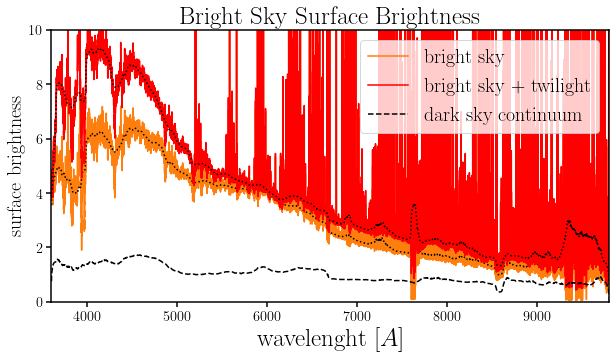

In [9]:
# arbitrary obs parameters
airmass = 1.2
moonill = 0.6
moonsep = 80.
moonalt = 60.
sunalt = -16.
sunsep = 90.

fig = plt.figure(figsize=(10,5))
sub = fig.add_subplot(111)
sub.plot(wave_lin, _sky_notwi(airmass, moonill, moonsep, moonalt), c='C1', label='bright sky')
sub.plot(wave_lin, _get_continuum(_sky_notwi(airmass, moonill, moonsep, moonalt))[0], c='k', ls=':')
sub.plot(wave_lin, _sky_notwi(airmass, moonill, moonsep, moonalt) + _sky_twi(airmass, sunsep, sunalt), 
         c='r', label='bright sky + twilight')
sub.plot(wave_lin, _get_continuum(_sky_notwi(airmass, moonill, moonsep, moonalt) + _sky_twi(airmass, sunsep, sunalt))[0],
         c='k', ls=':')
sub.plot(wave_lin, Isky_cont_dark, c='k', ls='--', label='dark sky continuum')
sub.legend(loc='upper right', fontsize=20, frameon=True)
sub.set_xlabel('wavelenght [$A$]', fontsize=25)
sub.set_xlim(3600, 9800)
sub.set_ylabel('surface brightness', fontsize=20)
sub.set_ylim(0, 10)
sub.set_title('Bright Sky Surface Brightness', fontsize=25)

In [10]:
def get_exp_param(): 
    ''' get observing parameters from surveysim output BGS exposures
    '''
    # read surveysim BGS exposures parameters 
    fsamp = os.path.join(UT.dat_dir(), 'bright_exposure', 
            'params.exp_samples.exposures_surveysim_fork_150s.npy') 
    # airmasses moon_ill moon_alt moon_sep sun_alt sun_sep 
    thetas = np.load(fsamp) 
    airmass, moonill, moonalt, moonsep, sun_alt, sun_sep = thetas.T # unpack the parameters
    bgs_exps = {} 
    bgs_exps['AIRMASS'] = airmass 
    bgs_exps['MOONFRAC'] = moonill  
    bgs_exps['MOONALT'] = moonalt 
    bgs_exps['MOONSEP'] = moonsep 
    bgs_exps['SUNALT'] = sun_alt
    bgs_exps['SUNSEP'] = sun_sep
    return bgs_exps

In [11]:
theta_exps = get_exp_param() 
n_exps = len(theta_exps['AIRMASS'])
print('%i exposures' % n_exps) 

5000 exposures


In [12]:
def get_Isky_exp(): 
    '''
    '''
    f_notwi = os.path.join(UT.dat_dir(), '_fit_skymodel.Isky_notwi.p') 
    f_twi = os.path.join(UT.dat_dir(), '_fit_skymodel.Isky_twi.p') 
    
    if os.path.isfile(f_notwi) and os.path.isfile(f_twi): 
        _Isky_notwi = pickle.load(open(f_notwi, 'rb'))
        _Isky_twi = pickle.load(open(f_twi, 'rb'))
    else: 
        _Isky_notwi, _Isky_twi = [], []
        for i in range(n_exps):
            _Isky_notwi.append(_sky_notwi(
                theta_exps['AIRMASS'][i], 
                theta_exps['MOONFRAC'][i], 
                theta_exps['MOONSEP'][i], 
                theta_exps['MOONALT'][i]))

            _Isky_twi.append(_sky_twi(
                theta_exps['AIRMASS'][i], 
                theta_exps['SUNSEP'][i], 
                theta_exps['SUNALT'][i]))
        pickle.dump(_Isky_notwi, open(f_notwi, 'wb'))
        pickle.dump(_Isky_twi, open(f_twi, 'wb'))
        
    return _Isky_notwi, _Isky_twi

In [13]:
Isky_notwi_exps, Isky_twi_exps = get_Isky_exp()

(0, 10)

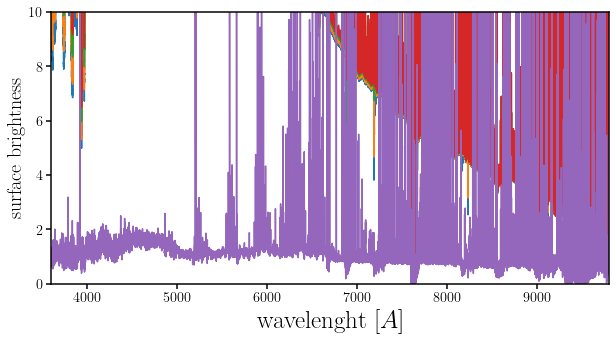

In [14]:
fig = plt.figure(figsize=(10,5))
sub = fig.add_subplot(111) 
for i in range(5): 
    sub.plot(wave_lin, Isky_notwi_exps[i])
sub.set_xlabel('wavelenght [$A$]', fontsize=25)
sub.set_xlim(3600, 9800)
sub.set_ylabel('surface brightness', fontsize=20)
sub.set_ylim(0, 10)

Text(0.5, 0.98, 'BGS exposures from surveysim')

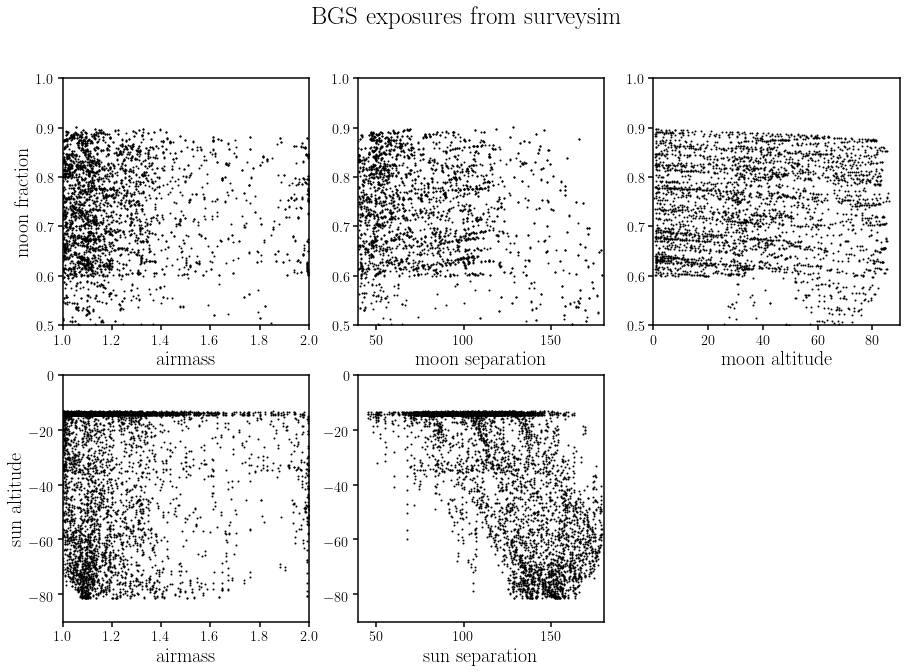

In [15]:
fig = plt.figure(figsize=(15,10))
sub = fig.add_subplot(231)
sub.scatter(theta_exps['AIRMASS'], theta_exps['MOONFRAC'], c='k', s=1)
sub.set_xlabel('airmass', fontsize=20)
sub.set_xlim([1., 2.])
sub.set_ylabel('moon fraction', fontsize=20)
sub.set_ylim([0.5, 1.])

sub = fig.add_subplot(232)
sub.scatter(theta_exps['MOONSEP'], theta_exps['MOONFRAC'], c='k', s=1)
sub.set_xlabel('moon separation', fontsize=20)
sub.set_xlim([40., 180.])
sub.set_ylim([0.5, 1.])

sub = fig.add_subplot(233)
sub.scatter(theta_exps['MOONALT'], theta_exps['MOONFRAC'], c='k', s=1)
sub.set_xlabel('moon altitude', fontsize=20)
sub.set_xlim([0., 90.])
sub.set_ylim([0.5, 1.])

sub = fig.add_subplot(234)
sub.scatter(theta_exps['AIRMASS'], theta_exps['SUNALT'], c='k', s=1)
sub.set_xlabel('airmass', fontsize=20)
sub.set_xlim([1., 2.])
sub.set_ylabel('sun altitude', fontsize=20)
sub.set_ylim([-90, 0.])

sub = fig.add_subplot(235)
sub.scatter(theta_exps['SUNSEP'], theta_exps['SUNALT'], c='k', s=1)
sub.set_xlabel('sun separation', fontsize=20)
sub.set_xlim([40., 180.])
sub.set_ylim([-90, 0.])
fig.suptitle('BGS exposures from surveysim', fontsize=25)

In [16]:
def get_exposure_factor(Isky, wavelength=4500.): 
    # get continuum sky surface brightness
    Isky_cont = _get_continuum(np.array(Isky))
    
    # calculate exposure factor at specified wavelength 
    wlim = (wave_lin > wavelength-500.) & (wave_lin > wavelength+500) # +/- 500 Angstroms
    
    fexp = np.median((Isky_cont/Isky_cont_dark)[:,wlim], axis=1)
    return fexp

In [17]:
def _bgs_fexp_notwi(wavelength=4500):
    f_notwi = os.path.join(UT.dat_dir(), '_fit_skymodel.fexp_notwi.%.f.p' % wavelength) 
    
    if os.path.isfile(f_notwi): 
        _fexp_notwi = pickle.load(open(f_notwi, 'rb'))
    else: 
        _fexp_notwi = get_exposure_factor(Isky_notwi_exps, wavelength=wavelength)
        pickle.dump(_fexp_notwi, open(f_notwi, 'wb'))
    return _fexp_notwi

def _bgs_dfexp_twi(wavelength=4500):
    f_twi = os.path.join(UT.dat_dir(), '_fit_skymodel.dfexp_twi.%.f.p' % wavelength) 
    
    if os.path.isfile(f_twi): 
        _dfexp_twi = pickle.load(open(f_twi, 'rb'))
    else: 
        _dfexp_twi = get_exposure_factor(Isky_twi_exps, wavelength=wavelength)
        nottwi = (theta_exps['SUNALT'] < -20.)
        _dfexp_twi[nottwi] = 0.
        pickle.dump(_dfexp_twi, open(f_twi, 'wb'))
    return _dfexp_twi

In [18]:
bgs_fexp_notwi_4500 = _bgs_fexp_notwi(wavelength=4500.)

In [19]:
bgs_dfexp_twi_4500 = _bgs_dfexp_twi(wavelength=4500.)
bgs_dfexp_twi_4500 = np.clip(bgs_dfexp_twi_4500, 0., None)

(-90, 0.0)

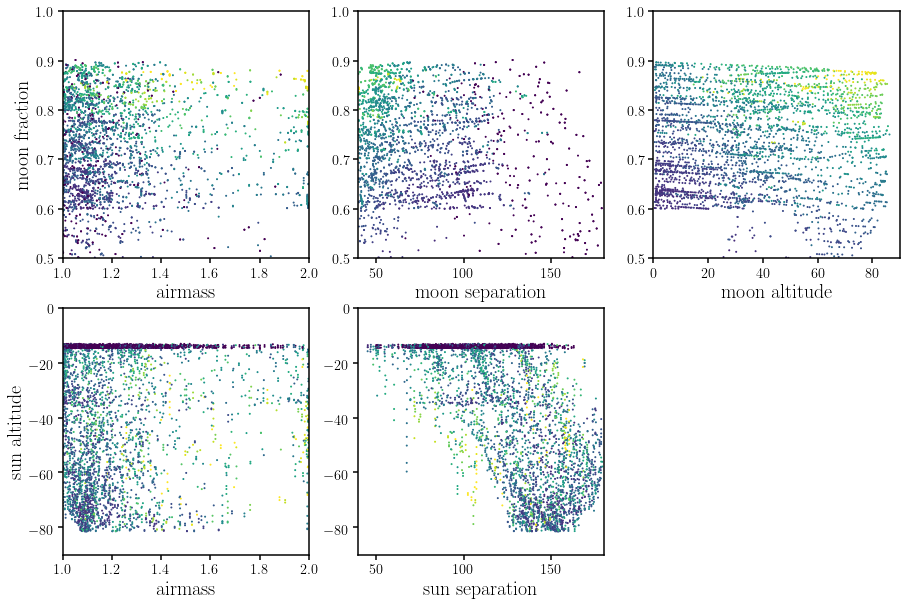

In [20]:
fig = plt.figure(figsize=(15,10))
sub = fig.add_subplot(231)
sub.scatter(theta_exps['AIRMASS'], theta_exps['MOONFRAC'], s=1, c=bgs_fexp_notwi_4500, vmin=1., vmax=10.)
sub.set_xlabel('airmass', fontsize=20)
sub.set_xlim([1., 2.])
sub.set_ylabel('moon fraction', fontsize=20)
sub.set_ylim([0.5, 1.])

sub = fig.add_subplot(232)
sub.scatter(theta_exps['MOONSEP'], theta_exps['MOONFRAC'], s=1, c=bgs_fexp_notwi_4500, vmin=1., vmax=10.)
sub.set_xlabel('moon separation', fontsize=20)
sub.set_xlim([40., 180.])
sub.set_ylim([0.5, 1.])

sub = fig.add_subplot(233)
sub.scatter(theta_exps['MOONALT'], theta_exps['MOONFRAC'], s=1, c=bgs_fexp_notwi_4500, vmin=1., vmax=10.)
sub.set_xlabel('moon altitude', fontsize=20)
sub.set_xlim([0., 90.])
sub.set_ylim([0.5, 1.])

sub = fig.add_subplot(234)
sub.scatter(theta_exps['AIRMASS'], theta_exps['SUNALT'], s=1, c=bgs_fexp_notwi_4500, vmin=1., vmax=10.)
sub.set_xlabel('airmass', fontsize=20)
sub.set_xlim([1., 2.])
sub.set_ylabel('sun altitude', fontsize=20)
sub.set_ylim([-90, 0.])

sub = fig.add_subplot(235)
sub.scatter(theta_exps['SUNSEP'], theta_exps['SUNALT'], s=1, c=bgs_fexp_notwi_4500, vmin=1., vmax=10.)
sub.set_xlabel('sun separation', fontsize=20)
sub.set_xlim([40., 180.])
sub.set_ylim([-90, 0.])

(-90, 0.0)

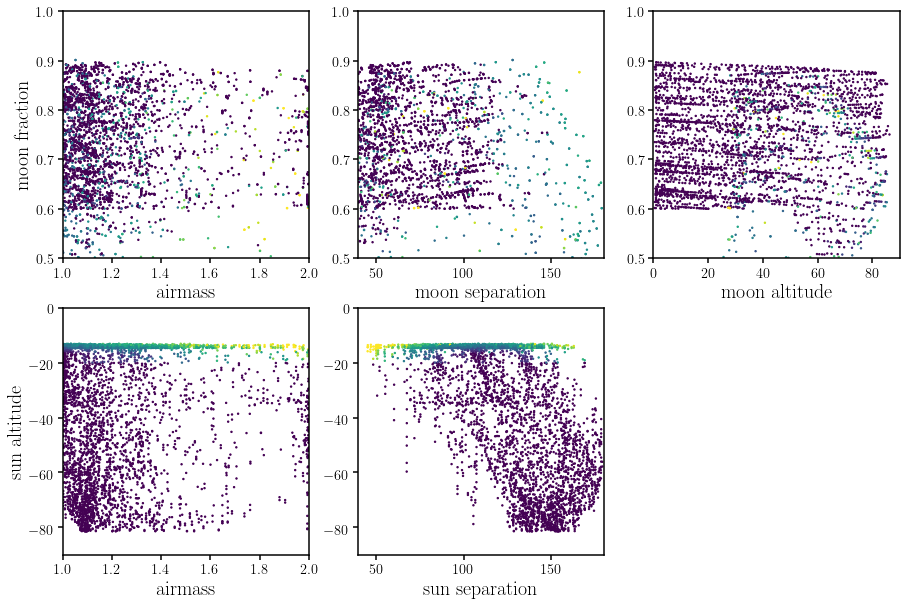

In [21]:
fig = plt.figure(figsize=(15,10))
sub = fig.add_subplot(231)
sub.scatter(theta_exps['AIRMASS'], theta_exps['MOONFRAC'], s=2, c=bgs_dfexp_twi_4500, vmin=0., vmax=2.)
sub.set_xlabel('airmass', fontsize=20)
sub.set_xlim([1., 2.])
sub.set_ylabel('moon fraction', fontsize=20)
sub.set_ylim([0.5, 1.])

sub = fig.add_subplot(232)
sub.scatter(theta_exps['MOONSEP'], theta_exps['MOONFRAC'], s=2, c=bgs_dfexp_twi_4500, vmin=0., vmax=2.)
sub.set_xlabel('moon separation', fontsize=20)
sub.set_xlim([40., 180.])
sub.set_ylim([0.5, 1.])

sub = fig.add_subplot(233)
sub.scatter(theta_exps['MOONALT'], theta_exps['MOONFRAC'], s=2, c=bgs_dfexp_twi_4500, vmin=0., vmax=2.)
sub.set_xlabel('moon altitude', fontsize=20)
sub.set_xlim([0., 90.])
sub.set_ylim([0.5, 1.])

sub = fig.add_subplot(234)
sub.scatter(theta_exps['AIRMASS'], theta_exps['SUNALT'], s=2, c=bgs_dfexp_twi_4500, vmin=0., vmax=2.)
sub.set_xlabel('airmass', fontsize=20)
sub.set_xlim([1., 2.])
sub.set_ylabel('sun altitude', fontsize=20)
sub.set_ylim([-90, 0.])

sub = fig.add_subplot(235)
sub.scatter(theta_exps['SUNSEP'], theta_exps['SUNALT'], s=2, c=bgs_dfexp_twi_4500, vmin=0., vmax=2.)
sub.set_xlabel('sun separation', fontsize=20)
sub.set_xlim([40., 180.])
sub.set_ylim([-90, 0.])

In [33]:
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from itertools import chain, combinations_with_replacement

In [34]:
theta_train, theta_test, bgs_fexp_notwi_4500_train, bgs_fexp_notwi_4500_test = train_test_split(
    np.vstack([theta_exps['AIRMASS'], 
               theta_exps['MOONFRAC'], 
               theta_exps['MOONSEP'], 
               theta_exps['MOONALT']]).T, 
    bgs_fexp_notwi_4500, 
    test_size=0.2, 
    random_state=0)

Text(0.5, 0.98, 'train vs test set')

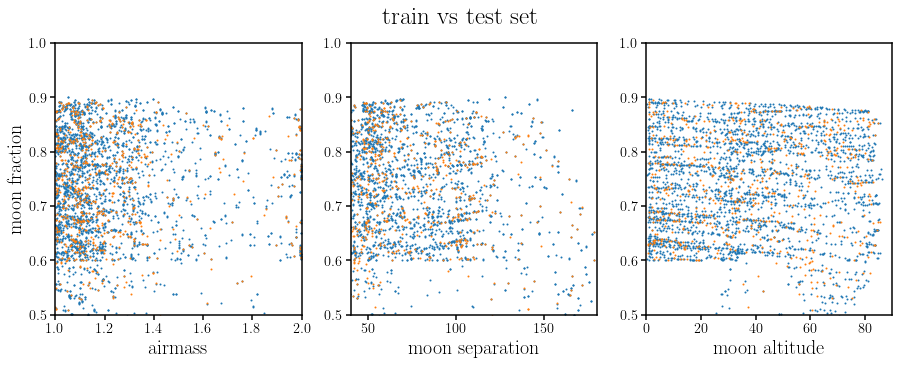

In [35]:
fig = plt.figure(figsize=(15,5))
sub = fig.add_subplot(131)
sub.scatter(theta_train[:,0], theta_train[:,1], c='C0', s=1)
sub.scatter(theta_test[:,0], theta_test[:,1], c='C1', s=1)
sub.set_xlabel('airmass', fontsize=20)
sub.set_xlim([1., 2.])
sub.set_ylabel('moon fraction', fontsize=20)
sub.set_ylim([0.5, 1.])

sub = fig.add_subplot(132)
sub.scatter(theta_train[:,2], theta_train[:,1], c='C0', s=1)
sub.scatter(theta_test[:,2], theta_test[:,1], c='C1', s=1)
sub.set_xlabel('moon separation', fontsize=20)
sub.set_xlim([40., 180.])
sub.set_ylim([0.5, 1.])

sub = fig.add_subplot(133)
sub.scatter(theta_train[:,3], theta_train[:,1], c='C0', s=1)
sub.scatter(theta_test[:,3], theta_test[:,1], c='C1', s=1)
sub.set_xlabel('moon altitude', fontsize=20)
sub.set_xlim([0., 90.])
sub.set_ylim([0.5, 1.])
fig.suptitle('train vs test set', fontsize=25)

## exposure factor fits at 4500$A$

In [36]:
regress_fexp_notwi_4500 = make_pipeline(PolynomialFeatures(3), LinearRegression())
regress_fexp_notwi_4500.fit(theta_train, bgs_fexp_notwi_4500_train)

Pipeline(memory=None,
         steps=[('polynomialfeatures',
                 PolynomialFeatures(degree=3, include_bias=True,
                                    interaction_only=False, order='C')),
                ('linearregression',
                 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                  normalize=False))],
         verbose=False)

In [37]:
steps = regress_fexp_notwi_4500.get_params()
print(steps['linearregression'].coef_)
print(steps['linearregression'].intercept_)

[ 1.71573612e-09 -5.60790479e-01 -1.48073306e+00  1.15296186e-01
  4.52848807e-02  6.87825142e-01 -1.09204980e-01 -2.29003929e-02
  5.43115007e-02  3.73159137e+00 -1.02979745e-02 -7.54139533e-02
 -1.05738392e-03 -1.40087568e-03 -1.61643490e-04 -4.83874245e-01
 -1.27069698e+00  3.10724722e-02  6.37391242e-03  6.03557732e+00
  1.93135069e-02  6.44469267e-02 -4.85686295e-04 -1.14612065e-03
 -5.46053442e-04  4.53593491e-01 -6.38120677e-02  1.30231834e-01
  6.98885410e-05 -7.61371808e-04 -9.32261381e-04  6.59488169e-06
  1.78548384e-05  1.37397769e-05  2.42228917e-06]
-1.9417946048367711


In [38]:
_notwiCoefficients_4500 = np.array([1.71573612e-09, -5.60790479e-01, -1.48073306e+00,
     1.15296186e-01, 4.52848807e-02,  6.87825142e-01, -1.09204980e-01,
     -2.29003929e-02, 5.43115007e-02,  3.73159137e+00, -1.02979745e-02,
     -7.54139533e-02, -1.05738392e-03, -1.40087568e-03, -1.61643490e-04,
     -4.83874245e-01, -1.27069698e+00,  3.10724722e-02,  6.37391242e-03,
     6.03557732e+00, 1.93135069e-02,  6.44469267e-02, -4.85686295e-04,
     -1.14612065e-03, -5.46053442e-04,  4.53593491e-01, -6.38120677e-02,
     1.30231834e-01, 6.98885410e-05, -7.61371808e-04, -9.32261381e-04,
     6.59488169e-06, 1.78548384e-05,  1.37397769e-05,  2.42228917e-06])

def _bright_exposure_factor_notwi(airmass, moon_frac, moon_sep, moon_alt, wavelength=4500):
    ''' third degree polynomial regression fit to exposure factor
    '''
    theta = np.atleast_2d(np.array([airmass, moon_frac, moon_sep, moon_alt]).T)

    combs = chain.from_iterable(combinations_with_replacement(range(4), i) for i in range(0, 4))
    theta_transform = np.empty((theta.shape[0], 35))
    for i, comb in enumerate(combs):
        theta_transform[:, i] = theta[:, comb].prod(1)
        
    if wavelength == 4500:
        _notwiCoefficients = _notwiCoefficients_4500
        _notwiIntercept = -1.9417946048367711

    return np.dot(theta_transform, _notwiCoefficients.T) + _notwiIntercept

In [39]:
bgs_fexp_notwi_4500_pred = regress_fexp_notwi_4500.predict(theta_test)

In [40]:
_bgs_fexp_notwi_4500_pred = _bright_exposure_factor_notwi(theta_test[:,0], theta_test[:,1], theta_test[:,2], theta_test[:,3])

In [41]:
(np.abs(bgs_fexp_notwi_4500_pred - _bgs_fexp_notwi_4500_pred)).max()

1.391355155533347e-07

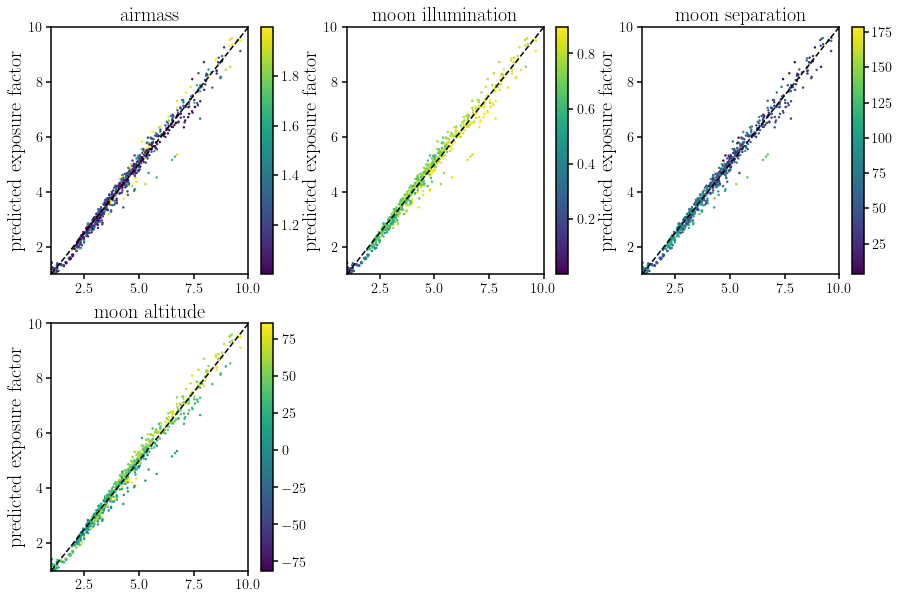

In [42]:
lbls = ['airmass', 'moon illumination', 'moon separation', 'moon altitude', 'sun separation', 'sun altitude']

fig = plt.figure(figsize=(15,10))
for i in range(4): 
    sub = fig.add_subplot(2,3,i+1)
    sub.plot([1., 20.], [1., 20.], c='k', ls='--')
    _plt = sub.scatter(bgs_fexp_notwi_4500_test, bgs_fexp_notwi_4500_pred, c=theta_test[:,i], s=2)
    if i > 3: sub.set_xlabel('test exposure factor', fontsize=20)
    sub.set_xlim([1., 10.])
    sub.set_ylabel('predicted exposure factor', fontsize=20)
    sub.set_ylim([1., 10.])
    sub.set_title(lbls[i], fontsize=20)
    fig.colorbar(_plt)

In [43]:
is_twilight = (theta_exps['SUNALT'] >= -20.)

theta_train, theta_test, bgs_dfexp_twi_4500_train, bgs_dfexp_twi_4500_test = train_test_split(
    np.vstack([theta_exps['AIRMASS'][is_twilight], 
               theta_exps['SUNSEP'][is_twilight], 
               theta_exps['SUNALT'][is_twilight]]).T, 
    bgs_dfexp_twi_4500[is_twilight], 
    test_size=0.2, 
    random_state=0)

In [44]:
regress_dfexp_twi_4500 = LinearRegression()
regress_dfexp_twi_4500.fit(theta_train, bgs_dfexp_twi_4500_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [45]:
bgs_dfexp_twi_4500_pred = regress_dfexp_twi_4500.predict(theta_test)

In [46]:
regress_dfexp_twi_4500.coef_

array([ 1.37980334, -0.00460065,  0.17337445])

In [47]:
regress_dfexp_twi_4500.intercept_

2.217660156188111

In [48]:
def _bright_exposure_factor_twi(airmass, sun_sep, sun_alt, wavelength=4500):
    ''' third degree polynomial regression fit to exposure factor
    '''
    theta = np.atleast_2d(np.array([airmass, sun_sep, sun_alt]).T)
        
    if wavelength == 4500:
        _twiCoefficients = np.array([1.37980334, -0.00460065,  0.17337445])
        _twiIntercept = 2.217660156188111

    return np.dot(theta, _twiCoefficients.T) + _twiIntercept

In [49]:
_bgs_dfexp_twi_4500_pred = _bright_exposure_factor_twi(theta_test[:,0], theta_test[:,1], theta_test[:,2])
print((np.abs(bgs_dfexp_twi_4500_pred - _bgs_dfexp_twi_4500_pred)).max())

4.840828491392557e-07


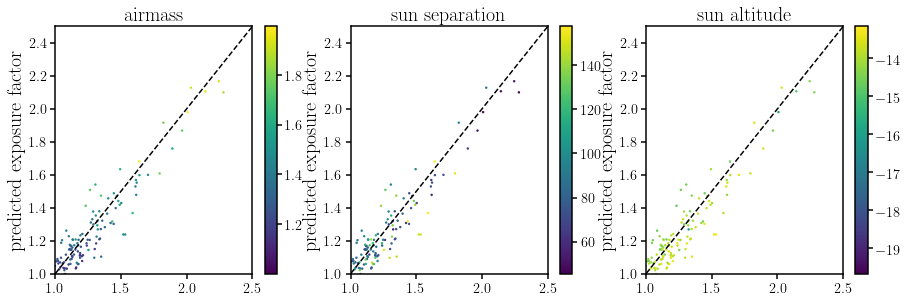

In [50]:
lbls = ['airmass', 'sun separation', 'sun altitude']

fig = plt.figure(figsize=(15,10))
for i in range(theta_test.shape[1]): 
    sub = fig.add_subplot(2,3,i+1)
    sub.plot([1., 20.], [1., 20.], c='k', ls='--')
    _plt = sub.scatter(bgs_dfexp_twi_4500_test, bgs_dfexp_twi_4500_pred, c=theta_test[:,i], s=2)
    if i > 3: sub.set_xlabel('test exposure factor', fontsize=20)
    sub.set_xlim([1., 2.5])
    sub.set_ylabel('predicted exposure factor', fontsize=20)
    sub.set_ylim([1., 2.5])
    sub.set_title(lbls[i], fontsize=20)
    fig.colorbar(_plt)

## exposure factor fits at 7000$A$

In [52]:
bgs_fexp_notwi_7000 = _bgs_fexp_notwi(wavelength=7000.)
bgs_dfexp_twi_7000 = _bgs_dfexp_twi(wavelength=7000.)

In [53]:
theta_train, theta_test, bgs_fexp_notwi_7000_train, bgs_fexp_notwi_7000_test = train_test_split(
    np.vstack([theta_exps['AIRMASS'], 
               theta_exps['MOONFRAC'], 
               theta_exps['MOONSEP'], 
               theta_exps['MOONALT']]).T, 
    bgs_fexp_notwi_7000, 
    test_size=0.2, 
    random_state=0)

regress_fexp_notwi_7000 = make_pipeline(PolynomialFeatures(3), LinearRegression())
regress_fexp_notwi_7000.fit(theta_train, bgs_fexp_notwi_7000_train)

Pipeline(memory=None,
         steps=[('polynomialfeatures',
                 PolynomialFeatures(degree=3, include_bias=True,
                                    interaction_only=False, order='C')),
                ('linearregression',
                 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                  normalize=False))],
         verbose=False)

In [63]:
steps = regress_fexp_notwi_7000.get_params()
steps['linearregression'].coef_

array([-5.02769612e-09,  8.95781363e-01, -1.98949612e+00,  7.59376004e-02,
        3.61941895e-02, -6.34124234e-01,  9.82024382e-01, -1.45026008e-02,
        3.17465022e-02,  5.07497967e+00, -1.61120887e-02, -8.06403621e-02,
       -6.87578739e-04, -9.03149875e-04,  2.94092504e-05, -2.16338069e-02,
       -1.33114000e+00,  2.10489148e-02,  6.51274399e-03,  4.09227919e+00,
        1.53579018e-02,  4.02131950e-02, -3.34303641e-04, -7.77138042e-04,
       -3.93654140e-04, -1.95761616e+00, -3.77209064e-02,  1.03445517e-01,
        5.93690315e-05, -3.85028908e-04, -7.90983761e-04,  4.33510170e-06,
        1.16096223e-05,  9.03060380e-06,  2.37397368e-06])

In [62]:
print(steps['linearregression'].intercept_)

-1.451246068647658


In [55]:
bgs_fexp_notwi_7000_pred = regress_fexp_notwi_7000.predict(theta_test)

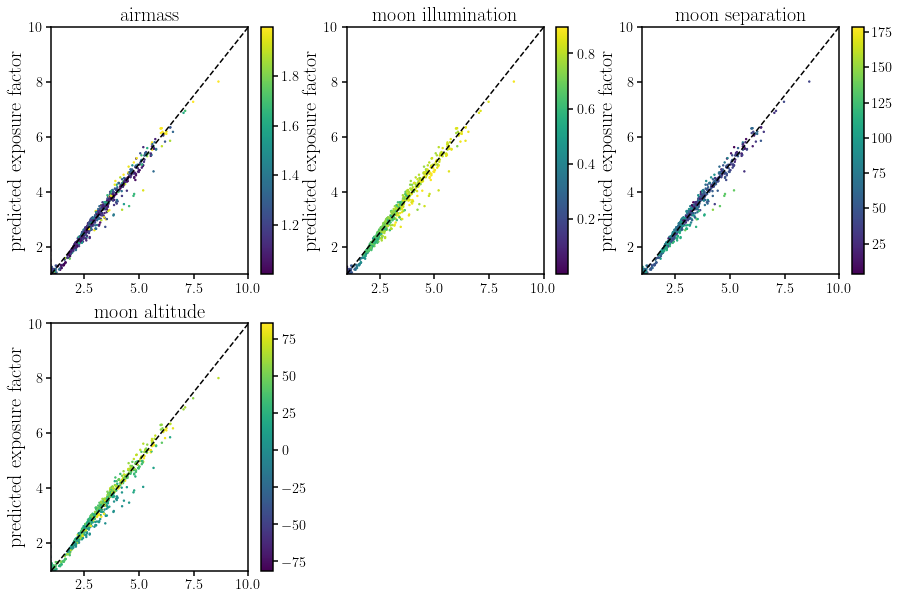

In [56]:
lbls = ['airmass', 'moon illumination', 'moon separation', 'moon altitude']

fig = plt.figure(figsize=(15,10))
for i in range(4): 
    sub = fig.add_subplot(2,3,i+1)
    sub.plot([1., 20.], [1., 20.], c='k', ls='--')
    _plt = sub.scatter(bgs_fexp_notwi_7000_test, bgs_fexp_notwi_7000_pred, c=theta_test[:,i], s=2)
    if i > 3: sub.set_xlabel('test exposure factor', fontsize=20)
    sub.set_xlim([1., 10.])
    sub.set_ylabel('predicted exposure factor', fontsize=20)
    sub.set_ylim([1., 10.])
    sub.set_title(lbls[i], fontsize=20)
    fig.colorbar(_plt)

In [57]:
is_twilight = (theta_exps['SUNALT'] >= -20.)

theta_train, theta_test, bgs_dfexp_twi_7000_train, bgs_dfexp_twi_7000_test = train_test_split(
    np.vstack([theta_exps['AIRMASS'][is_twilight], 
               theta_exps['SUNSEP'][is_twilight], 
               theta_exps['SUNALT'][is_twilight]]).T, 
    np.clip(bgs_dfexp_twi_7000[is_twilight], 0., None), 
    test_size=0.2, 
    random_state=0)

In [58]:
regress_dfexp_twi_7000 = LinearRegression()
regress_dfexp_twi_7000.fit(theta_train, bgs_dfexp_twi_7000_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [59]:
bgs_dfexp_twi_7000_pred = regress_dfexp_twi_7000.predict(theta_test)

In [60]:
print(regress_dfexp_twi_7000.coef_)
print(regress_dfexp_twi_7000.intercept_)

[ 1.1139712  -0.00431072  0.16183842]
2.3278959318651733


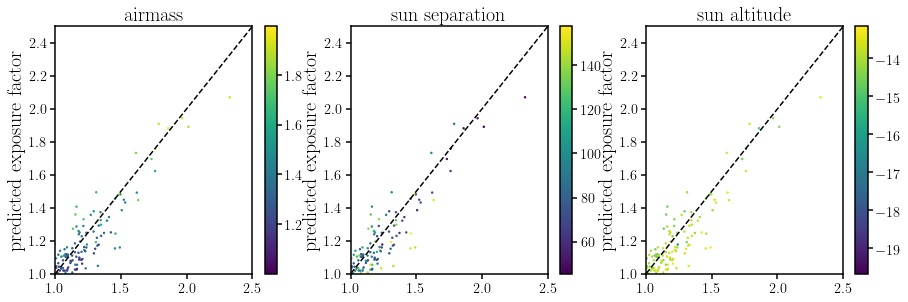

In [61]:
lbls = ['airmass', 'sun separation', 'sun altitude']

fig = plt.figure(figsize=(15,10))
for i in range(theta_test.shape[1]): 
    sub = fig.add_subplot(2,3,i+1)
    sub.plot([1., 20.], [1., 20.], c='k', ls='--')
    _plt = sub.scatter(bgs_dfexp_twi_7000_test, bgs_dfexp_twi_7000_pred, c=theta_test[:,i], s=2)
    if i > 3: sub.set_xlabel('test exposure factor', fontsize=20)
    sub.set_xlim([1., 2.5])
    sub.set_ylabel('predicted exposure factor', fontsize=20)
    sub.set_ylim([1., 2.5])
    sub.set_title(lbls[i], fontsize=20)
    fig.colorbar(_plt)